# DCGAN Tutorial
***
* Original Author: [Nathan Inkawhich](https://github.com/inkawhich)
* Translator: [조민성](https://github.com/miNept)
* Edited: [안재한](https://github.com/Dev-Jahn)

# 적대적 생성 신경망(Generative Adversarial Networks)
***
## GAN이란?
***
학습 데이터들의 분포를 학습해, 같은 분포에서 새로운 데이터를 생성할 수 있도록 모델을 학습시키는 학습 방법론
> [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) by Ian Goodfellow (2014)

* GAN은 *Generator* 와 *Discriminator* 로 구별되는 두가지 모델을 가지고 있는것이 특징
* Generator의 역할은 실제 이미지로 착각되도록 정교한 이미지를 만드는 것
* Discriminator의 역할은 이미지를 보고 Generator에 의해 만들어진 이미지인지 실제 이미지인지 알아내는 것

![image](https://mblogthumb-phinf.pstatic.net/MjAxOTA3MjRfMzAw/MDAxNTYzOTY2MjM4NTMx.X1wCeYWKi4Zs57ZrSHkHf9vk0EImiJiRcSY43OyeCN0g.aiSe5ewpV-Wf0PfH6ZGjRij6qftMua46OxQ3Uog3s0Eg.PNG.dnjswns2280/image.png?type=w800)

‘위조지폐범 vs 경찰’ 게임은, Generator가 학습 데이터들에서 직접 가져온 것처럼 보일정도로 완벽한 이미지를 만들어내고,
Discriminator가 Generator에서 나온 이미지를 50%의 확률로 가짜 혹은 진짜로 판별할 때, 균형상태에 도달하게 됩니다.

그럼 이제부터 본 튜토리얼에서 사용할 표기들을 Discriminator부터 정의해보겠습니다. $x$ 는 이미지로 표현되는 데이터로 두겠습니다.
$D(x)$ 는 Discriminator 신경망이고, 실제 학습데이터에서 가져온 $x$ 를 통과시켜 상수(scalar) 확률값을 결과로 출려합니다.
이때, 우리는 이미지 데이터를 다루고 있으므로, $D(x)$ 에는 3x64x64크기의 CHW 데이터가 입력됩니다. 직관적으로 볼때,
$D(x)$ 는 $x$ 가 학습데이터에서 가져온 것일 때 출력이 크고, Generator가 만들어낸 $x$ 일때 작을 것입니다.
$D(x)$ 는 전통적인 이진 분류기(binary classification)으로도 생각될 수 있습니다.

이번엔 Generator의 표기들을 확인해봅시다. $z$ 를 정규분포에서 뽑은 잠재공간 벡터(laten space vector)라고 하겠습니다
(번역 주. laten space vector는 쉽게 생각해 정규분포를 따르는 n개의 원소를 가진 vector라 볼 수 있습니다.
다르게 얘기하면 정규분포에서 n개의 원소를 추출한 것과 같습니다). $G(z)$ 는 $z$
벡터를 원하는 데이터 차원으로 대응시키는 신경망으로 둘 수 있습니다. 이때 $G$ 의 목적은 $p_{data}$
에서 얻을 수 있는 학습 데이터들의 분포를 추정하여, 모사한 $p_g$ 의 분포를 이용해 가짜 데이터들을 만드는 것입니다.

이어서, $D(G(z))$ 는 $G$ 가 출력한 결과물이 실제 이미지일 0~1사이의 상수의 확률값입니다.
`Goodfellow의 논문 <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__
에 기술되어 있듯, $D$ 가 이미지의 참/거짓을 정확히 판별할 확률인 $logD(x)$를 최대화 시키고,
$G$ 에서 생성한 이미지를 $D$ 가 가짜로 판별할 확률인
($log(1-D(G(z)))$)를 최소화 시키려는 점에서, $D$ 와 $G$ 는 최대최소(minmax)게임을 하는 것과 같습니다.

## GAN의 손실함수 (GAN loss, Minimax loss)
\begin{align}\underset{G}{\text{min}} \ \underset{D}{\text{max}} \ V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

이론적으로는, 이 최대최소게임은 $p_g = p_{data}$ 이고, Discriminator에 입력된 데이터가 1/2의 무작위 확률로 참/거짓이 판별될때 해답에 이릅니다.
하지만 GAN의 수렴 이론은 아직도 활발히 연구가 진행중이고, 현실에서의 모델들은 이론적인 최적 상태에 도달하지 않는 경우도 많습니다.

## DCGAN은?
***
Generator와 Discriminator에 Convolution Convolution-transpose을 사용한 GAN
> [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) (Radford, et al)
### 이전 GAN과의 차이
***
#### Discriminator
* [convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) 레이어
* [배치 정규화(batch norm)](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) 레이어
* [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) 활성화함수
사용

* 입력: 3x64x64 이미지
* 출력: 입력 데이터가 실제 데이터일 0~1사이의 확률값

#### Generator
* [전치 합성곱(convolutional-transpose)](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) 레이어
* 배치 정규화(batch norm) 레이어
* [ReLU](https://pytorch.org/docs/stable/nn.html#relu) 활성화함수
사용

* 입력: 정규분포에서 추출한 잠재공간 벡터 $z$
* 출력: 3x64x64 RGB 이미지

전치 합성곱 레이어는 잠재공간 벡터가 이미지와 같은 차원을 갖도록 업스케일 해주는 역할 (합성곱의 반대)

## 데이터셋 준비
***
실습에 앞서 데이터셋을 구글드라이브에서 받아줍니다

colab에서 쓰실분은
> 아래 링크 클릭 > 구글드라이브 공유문서함에서 data폴더 우클릭 > 드라이브에 바로가기 추가 > 내 드라이브 선택 후 바로가기 추가

> 구글 드라이브 링크 [[link]](https://drive.google.com/drive/folders/1OjXWJZSsfThJC5TtEFt1SskVxQWegUoB?usp=sharing)
(CelebA, COCO2017-truncated 포함)

In [ ]:
# Colab에서 데이터 다운로드 시
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/data /content
!unzip /content/data/celeba/img_align_celeba.zip -d /content/data/celeba
# 바로가기 추가시 경로를 변경하신분은 MyDrive/data부분을 변경하신 경로로 설정하세요

In [3]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정
seed = 42
random.seed(seed)
torch.manual_seed(seed)
pass

## Configs and hyperparameters
------
-  **dataroot** - 데이터셋 폴더의 경로
-  **workers** - DataLoader에서 데이터를 불러올 때 사용할 스레드의 개수. GPU 1개당 4정도가 적당.
-  **batch_size** - 학습에 사용할 배치 크기. DCGAN 논문에서는 128 사용
-  **image_size** - 학습에 사용되는 이미지의 크기. 현재 모델은 64x64 기준, 바꾸고 싶다면 D와 G의 구조 역시 수정해야함. [참고링크](https://github.com/pytorch/examples/issues/70)
-  **nc** - 입력 이미지의 채널. RGB이므로 3.
-  **nz** - 잠재공간 벡터의 크기.
-  **ngf** - Generator를 통과할때 만들어질 feature의 채널.
-  **ndf** - Discriminator를 통과할때 만들어질 feature의 채널.
-  **num_epochs** - 학습시킬 에폭 수. 1epoch은 전체 데이터를 1회 순회.
-  **lr** - 옵티마이저의 학습률입니다. DCGAN 논문 기준, 0.0002
-  **beta1** - Adam의 beta1 하이퍼파라미터. 논문기준 0.5
-  **ngpu** - 사용할 GPU 갯수. 0->CPU, 1보다 크면 분산학습.

In [62]:
dataroot = "~/data"
workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

## CelebA dataset
***


In [71]:
dataset = CelebA(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

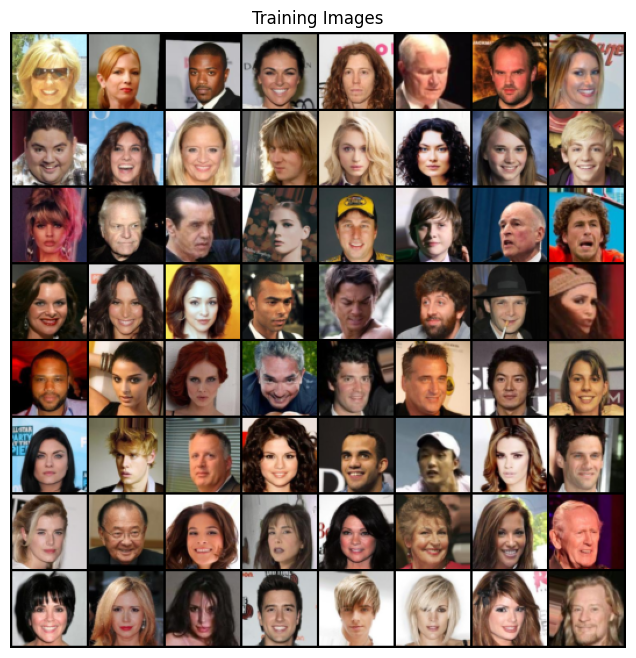

4.926480531692505


In [64]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## 구현
----
### 가중치 초기화

DCGAN 논문에서는, 평균이 0이고 분산이 0.02인 정규분포을 이용해 Discriminator와 Generator 모두 무작위 초기화를 진행하는 것이 좋다고 합니다

In [72]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator
***

Generator $G$ 는 잠재 공간 벡터 $z$ 를 데이터 공간으로 변환시키도록 학습됨

여기서 데이터는 이미지이므로 $z$ 를 데이터공간으로 변환한다는 뜻은 학습이미지와 같은 사이즈를 가진 RGB 이미지를 생성한다는 것
> ex) (100x1x1) -> (3x64x64)

* 실제 모델에서는 스트라이드(stride) 2를 가진 전치 합성곱 계층들을 이어서 구성
* 각 전치 합성곱 계층 하나당 2차원 배치 정규화 계층과 relu 활성함수를 한 쌍으로 묶어서 사용
* Generator의 마지막 출력 계층에서는 tanh 함수를 사용하는데, 이는 출력 값을 $[-1,1]$ 사이의 범위로 조정하기 위함

#### DCGAN 논문에서 제시한 Generator의 모델 아키텍쳐

![dcgan_generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

우리가 앞서 정의한 값들(`nz`, `ngf`, `nc`)이 Generator 모델 아키텍쳐에 어떻게 영향을 끼치는지 주목할 것
* `nz` 는 `z` 입력 벡터의 길이
* `ngf` 는 Generator를 통과하는 특징 데이터의 크기
* `nc` 는 출력 이미지의 채널 개수 (RGB이므로 3)

아래는 Generator의 코드입니다

In [73]:
# Generator 코드
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 레이어
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 여기까지 통과한 데이터의 크기. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 여기까지 통과한 데이터의 크기. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 여기까지 통과한 데이터의 크기. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 여기까지 통과한 데이터의 크기. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 여기까지 통과한 데이터의 크기. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Discriminator
***

Discriminator $D$는 입력 이미지가 진짜 이미지인지 가짜 이미지인지 판별하는 `이진 분류기`

3x64x64 이미지를 입력받아, Conv2d, BatchNorm2d, 그리고 LeakyReLU 계층을 통과시켜 특징을 추출하고

마지막 부분에서 Sigmoid 함수를 이용하여 0~1 사이로 출력값을 조정

DCGAN 논문에서는
* stride를 더한 합성곱을 사용하면 신경망 내에서 스스로 풀링(Pooling) 기능을 학습하기 때문에, 직접 풀링레이어 (MaxPool or AvgPool)을 사용하는 것보다 더 유리하다고 함
* 배치 정규화와 leaky relu 함수는 좀 더 안정적인 학습을 위해서

In [74]:
# Discriminator 코드
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [75]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)

# multi-gpu 사용시
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 손실함수와 옵티마이저
***
1. 손실함수로는 Binary Cross Entropy loss [(BCELoss)](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)를 사용

> $$\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}$$

    이때, 위의 함수가 로그함수 항을 정의한 방식을 보면
    y 를 변형해, BCE 함수를 우리가 원하는 목적함수로 그대로 사용할 수 있다는 사실을 알 수 있습니다.

> $log(D(x))$ 와 $log(1-D(G(z)))$

2. Real 라벨은 1로 두고, Fake 라벨은 0으로 설정

3. 서로 구분되는 두 옵티마이저를 구성
하나는 $D$, 다른 하나는 $G$ 를 위한 것

    DCGAN 논문대로, 두 옵티마이저는 모두 Adam을 사용하고, 학습률은 0.0002, Beta1 값은 0.5

* 추가적으로, 학습이 진행되는 동안 Generator의 상태를 알아보기 위해 고정된 잠재벡터를 생성(fixed_noise)

    학습 과정을 반복하면서  $G$ 에 주기적으로 같은 잠재벡터를 입력하면, 출력을 기반으로 Generator의 상태를 확인 가능

In [76]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion = nn.BCELoss()

# Generator의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training
***
실제 모델을 학습시키는 방법을 알아보겠습니다.
주의할 점은, GAN을 학습시킬 때 중요한 것은 관례적인 기술들의 집합이기 때문에 잘못된 하이퍼파라미터의 설정은 모델의 학습을 망가뜨릴 수 있습니다.
Goodfellow의 논문에서 서술된 알고리즘을 기반으로,
[ganhacks](https://github.com/soumith/ganhacks)에서 사용된 몇가지 괜찮은 테크닉들을
더할 것입니다. 앞서 몇번 설명했지만, 우리의 의도는 “진짜 혹은 가짜 이미지를 구성”하고,
$logD(G(z))$ 를 최대화하는 G의 목적함수를 최적화 시키는 겁니다. 학습과정은 크게 두가지로 나눕니다.
Part 1은 Discriminator를, Part 2는 Generator를 업데이트하는 과정입니다.

**Part 1 - Discriminator의 학습**

Discriminator의 목적은 주어진 입력값이 진짜인지 가짜인지 판별하는 것임을 상기합시다.
Goodfellow의 말을 빌리자면, Discriminator는 “변화도(gradient)를 상승(ascending)시키며 훈련”하게 됩니다.
실전적으로 얘기하면, $log(D(x)) + log(1-D(G(z)))$ 를 최대화시키는 것과 같습니다.
ganhacks에서 미니 배치(mini-batch)를 분리하여 사용한 개념을 가져와서,
우리 역시 두가지 스텝으로 분리해 계산을 해보겠습니다. 먼저,
진짜 데이터들로만 이루어진 배치를 만들어 $D$ 에 통과시킵니다. 그 출력값으로 ($log(D(x))$) 의 손실값을 계산하고,
역전파 과정에서의 변화도들을 계산합니다. 여기까지가 첫번째 스텝입니다. 두번째 스텝에서는, 오로지 가짜 데이터들로만
이루어진 배치를 만들어 $D$ 에 통과시키고, 그 출력값으로 ($log(1-D(G(z)))$) 의 손실값을 계산해
역전파 변화도를 구하면 됩니다. 이때 두가지 스텝에서 나오는 변화도들은 *축적(accumulate)* 시켜야 합니다.
변화도까지 구했으니, 이제 옵티마이저를 사용해야겠죠. 파이토치의 함수를 호출해주면 알아서 변화도가 적용될겁니다.

**Part 2 - Generator의 학습**

오리지널 GAN 논문에 명시되어 있듯, Generator는 $log(1-D(G(z)))$ 을 최소화시키는 방향으로 학습합니다.
하지만 이 방식은 충분한 변화도를 제공하지 못함을 Goodfellow가 보여줬습니다. 특히 학습초기에는 더욱 문제를 일으키죠.
이를 해결하기 위해 $log(D(G(z)))$ 를 최대화 하는 방식으로 바꿔서 학습을 하겠습니다. 코드에서 구현하기
위해서는 : Part 1에서 한대로 Discriminator를 이용해 Generator의 출력값을 판별해주고, *진짜 라벨값* 을 이용해 G의 손실값을 구해줍니다.
그러면 구해진 손실값으로 변화도를 구하고, 최종적으로는 옵티마이저를 이용해 G의 가중치들을 업데이트시켜주면 됩니다.
언뜻 볼때는, Generator가 만들어낸 *가짜* 이미지에 *진짜* 라벨을 사용하는것이 직관적으로 위배가 될테지만, 이렇게 라벨을
바꿈으로써 $log(x)$ 라는 BCELoss의 일부분을 사용할 수 있게 합니다 (앞서 우리는 BCELoss에서 라벨을 이용해 원하는 로그 계산
요소를 고를 수 있음을 알아봤습니다).

마무리로 G의 훈련 상태를 알아보기 위하여, 몇가지 통계적인 수치들과, fixed_noise를 통과시킨
결과를 화면에 출력하는 코드를 추가하겠습니다. 이때 통계적인 수치들이라 함은 :

-  **Loss_D** - 진짜 데이터와 가짜 데이터들 모두에서 구해진 손실값. ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - Generator의 손실값. $log(D(G(z)))$
-  **D(x)** - Discriminator가 데이터를 판별한 확률값입니다. 처음에는 1에 가까운 값이다가,
   G가 학습할수록 0.5값에 수렴하게 됩니다.
-  **D(G(z))** - 가짜데이터들에 대한 Discriminator의 출력값입니다. 처음에는 0에 가까운 값이다가,
   G가 학습할수록 0.5에 수렴하게 됩니다


**Note:** 이후의 과정은 epoch의 수와 데이터의 수에 따라 시간이 좀 걸릴 수 있습니다

In [77]:
# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
        ############################
        # (1) Discriminator 업데이트 : log(D(x)) + log(1 - D(G(z)))를 최대화
        ###########################
        ## 진짜 데이터로 학습
        netD.zero_grad()
        # 배치사이즈와 사용할 디바이스를 조정
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터로 이루어진 배치를 D에 통과
        output = netD(real_cpu).view(-1)
        # Loss 구하기
        errD_real = criterion(output, label)
        # 역전파로 그래디언트 계산
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터로 학습
        # Generator에 사용할 잠재공간 벡터를 생성
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산
        errD_fake = criterion(output, label)
        # 역전파로 그래디언트 계산. 이때 앞서 계산한 그래디언트에 누적됨
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지에서 구한 손실값들을 더하기(Logging을 위해)
        errD = errD_real + errD_fake
        # D를 업데이트
        optimizerD.step()

        ############################
        # (2) Generator 신경망 업데이트 : log(D(G(z)))를 최대화
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/2544 [00:00<?, ?it/s]

[0/5][0/2544]	Loss_D: 1.8495	Loss_G: 4.9972	D(x): 0.4881	D(G(z)): 0.5797 / 0.0091
[0/5][50/2544]	Loss_D: 0.2144	Loss_G: 36.1802	D(x): 0.9164	D(G(z)): 0.0000 / 0.0000
[0/5][100/2544]	Loss_D: 0.8311	Loss_G: 9.7709	D(x): 0.6897	D(G(z)): 0.0059 / 0.0005
[0/5][150/2544]	Loss_D: 1.0098	Loss_G: 8.1225	D(x): 0.9800	D(G(z)): 0.4373 / 0.0013
[0/5][200/2544]	Loss_D: 0.2010	Loss_G: 4.0674	D(x): 0.8730	D(G(z)): 0.0369 / 0.0379
[0/5][250/2544]	Loss_D: 3.4074	Loss_G: 9.0121	D(x): 0.2093	D(G(z)): 0.0001 / 0.0004
[0/5][300/2544]	Loss_D: 0.5330	Loss_G: 5.3809	D(x): 0.9026	D(G(z)): 0.2890 / 0.0093
[0/5][350/2544]	Loss_D: 0.2584	Loss_G: 5.1440	D(x): 0.8931	D(G(z)): 0.0961 / 0.0097
[0/5][400/2544]	Loss_D: 0.3059	Loss_G: 5.3310	D(x): 0.9194	D(G(z)): 0.1740 / 0.0067
[0/5][450/2544]	Loss_D: 0.6315	Loss_G: 4.5958	D(x): 0.6922	D(G(z)): 0.0490 / 0.0385
[0/5][500/2544]	Loss_D: 0.6144	Loss_G: 6.8904	D(x): 0.9637	D(G(z)): 0.3700 / 0.0028
[0/5][550/2544]	Loss_D: 0.4742	Loss_G: 7.2845	D(x): 0.9159	D(G(z)): 0.2759 / 0

  0%|          | 0/2544 [00:00<?, ?it/s]

[1/5][0/2544]	Loss_D: 0.7866	Loss_G: 2.3653	D(x): 0.5572	D(G(z)): 0.0394 / 0.1645
[1/5][50/2544]	Loss_D: 0.5897	Loss_G: 2.3297	D(x): 0.7846	D(G(z)): 0.2421 / 0.1281
[1/5][100/2544]	Loss_D: 1.1472	Loss_G: 1.0332	D(x): 0.4249	D(G(z)): 0.0097 / 0.4614
[1/5][150/2544]	Loss_D: 0.4529	Loss_G: 5.0830	D(x): 0.9505	D(G(z)): 0.3045 / 0.0088
[1/5][200/2544]	Loss_D: 0.5588	Loss_G: 2.1611	D(x): 0.7263	D(G(z)): 0.1147 / 0.1572
[1/5][250/2544]	Loss_D: 0.3905	Loss_G: 3.9949	D(x): 0.8341	D(G(z)): 0.1566 / 0.0301
[1/5][300/2544]	Loss_D: 0.4523	Loss_G: 3.5077	D(x): 0.8472	D(G(z)): 0.2055 / 0.0465
[1/5][350/2544]	Loss_D: 0.5012	Loss_G: 2.9837	D(x): 0.8024	D(G(z)): 0.1890 / 0.0709
[1/5][400/2544]	Loss_D: 0.6763	Loss_G: 2.1426	D(x): 0.6025	D(G(z)): 0.0453 / 0.1860
[1/5][450/2544]	Loss_D: 0.4813	Loss_G: 4.8140	D(x): 0.8658	D(G(z)): 0.2465 / 0.0135
[1/5][500/2544]	Loss_D: 0.4000	Loss_G: 3.5855	D(x): 0.7255	D(G(z)): 0.0359 / 0.0643
[1/5][550/2544]	Loss_D: 1.3725	Loss_G: 1.4564	D(x): 0.3421	D(G(z)): 0.0059 / 0.

  0%|          | 0/2544 [00:00<?, ?it/s]

[2/5][0/2544]	Loss_D: 0.4695	Loss_G: 3.1973	D(x): 0.8126	D(G(z)): 0.2001 / 0.0537
[2/5][50/2544]	Loss_D: 0.7016	Loss_G: 2.1346	D(x): 0.6740	D(G(z)): 0.2055 / 0.1490
[2/5][100/2544]	Loss_D: 0.6517	Loss_G: 2.0302	D(x): 0.6170	D(G(z)): 0.0614 / 0.1810
[2/5][150/2544]	Loss_D: 0.7884	Loss_G: 1.1765	D(x): 0.5916	D(G(z)): 0.1440 / 0.3555
[2/5][200/2544]	Loss_D: 0.7403	Loss_G: 3.8494	D(x): 0.8919	D(G(z)): 0.4133 / 0.0290
[2/5][250/2544]	Loss_D: 0.6369	Loss_G: 3.6399	D(x): 0.8655	D(G(z)): 0.3468 / 0.0328
[2/5][300/2544]	Loss_D: 0.6694	Loss_G: 1.8435	D(x): 0.6241	D(G(z)): 0.0928 / 0.1984
[2/5][350/2544]	Loss_D: 0.6132	Loss_G: 2.3885	D(x): 0.7448	D(G(z)): 0.2116 / 0.1236
[2/5][400/2544]	Loss_D: 0.2830	Loss_G: 3.7513	D(x): 0.8387	D(G(z)): 0.0807 / 0.0377
[2/5][450/2544]	Loss_D: 0.8582	Loss_G: 1.1070	D(x): 0.5259	D(G(z)): 0.0881 / 0.3918
[2/5][500/2544]	Loss_D: 0.7276	Loss_G: 4.0246	D(x): 0.8989	D(G(z)): 0.4109 / 0.0316
[2/5][550/2544]	Loss_D: 1.1279	Loss_G: 5.7483	D(x): 0.9365	D(G(z)): 0.5896 / 0.

  0%|          | 0/2544 [00:00<?, ?it/s]

[3/5][0/2544]	Loss_D: 0.7357	Loss_G: 2.0161	D(x): 0.7337	D(G(z)): 0.2908 / 0.1699
[3/5][50/2544]	Loss_D: 0.3729	Loss_G: 2.7120	D(x): 0.7630	D(G(z)): 0.0612 / 0.0915
[3/5][100/2544]	Loss_D: 1.8921	Loss_G: 6.0984	D(x): 0.9627	D(G(z)): 0.7569 / 0.0055
[3/5][150/2544]	Loss_D: 0.4140	Loss_G: 2.4203	D(x): 0.7385	D(G(z)): 0.0646 / 0.1236
[3/5][200/2544]	Loss_D: 0.3242	Loss_G: 3.4287	D(x): 0.8712	D(G(z)): 0.1544 / 0.0439
[3/5][250/2544]	Loss_D: 0.3520	Loss_G: 3.0163	D(x): 0.8823	D(G(z)): 0.1791 / 0.0770
[3/5][300/2544]	Loss_D: 0.5183	Loss_G: 2.9826	D(x): 0.8123	D(G(z)): 0.2121 / 0.0673
[3/5][350/2544]	Loss_D: 0.3536	Loss_G: 3.0272	D(x): 0.8878	D(G(z)): 0.1962 / 0.0586
[3/5][400/2544]	Loss_D: 0.5602	Loss_G: 3.6753	D(x): 0.9078	D(G(z)): 0.3304 / 0.0376
[3/5][450/2544]	Loss_D: 3.1395	Loss_G: 6.8535	D(x): 0.9841	D(G(z)): 0.8805 / 0.0043
[3/5][500/2544]	Loss_D: 0.6094	Loss_G: 2.1383	D(x): 0.7671	D(G(z)): 0.2494 / 0.1470
[3/5][550/2544]	Loss_D: 0.4245	Loss_G: 2.4149	D(x): 0.7781	D(G(z)): 0.1271 / 0.

  0%|          | 0/2544 [00:00<?, ?it/s]

[4/5][0/2544]	Loss_D: 1.0250	Loss_G: 6.9236	D(x): 0.9714	D(G(z)): 0.5616 / 0.0019
[4/5][50/2544]	Loss_D: 0.4948	Loss_G: 1.8006	D(x): 0.7410	D(G(z)): 0.1348 / 0.1979
[4/5][100/2544]	Loss_D: 0.5166	Loss_G: 3.4487	D(x): 0.8858	D(G(z)): 0.2663 / 0.0478
[4/5][150/2544]	Loss_D: 0.3795	Loss_G: 3.3584	D(x): 0.7673	D(G(z)): 0.0725 / 0.0595
[4/5][200/2544]	Loss_D: 0.7422	Loss_G: 1.4585	D(x): 0.5647	D(G(z)): 0.0490 / 0.3138
[4/5][250/2544]	Loss_D: 0.5407	Loss_G: 4.9521	D(x): 0.9635	D(G(z)): 0.3452 / 0.0105
[4/5][300/2544]	Loss_D: 0.2606	Loss_G: 2.5027	D(x): 0.8585	D(G(z)): 0.0846 / 0.1126
[4/5][350/2544]	Loss_D: 0.3739	Loss_G: 1.9902	D(x): 0.7995	D(G(z)): 0.1158 / 0.1638
[4/5][400/2544]	Loss_D: 0.4765	Loss_G: 2.0033	D(x): 0.7269	D(G(z)): 0.1030 / 0.1756
[4/5][450/2544]	Loss_D: 0.7322	Loss_G: 4.8209	D(x): 0.9244	D(G(z)): 0.4079 / 0.0128
[4/5][500/2544]	Loss_D: 0.6765	Loss_G: 4.6647	D(x): 0.9585	D(G(z)): 0.4097 / 0.0152
[4/5][550/2544]	Loss_D: 0.4523	Loss_G: 3.6184	D(x): 0.9238	D(G(z)): 0.2842 / 0.

In [44]:
from torchvision.transforms import ToPILImage
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
data, label = next(iter(dataloader))
ToPILImage()(vutils.make_grid(fake, padding=2, normalize=True))

## 결과 확인
***

결과를 알아봅시다. 이 섹션에서는 총 세가지를 확인할겁니다.
첫번째는 G와 D의 손실값들이 어떻게 변했는가, 두번째는 매 에폭마다
fixed_noise를 이용해 G가 만들어낸 이미지들, 마지막은 학습이 끝난 G가 만들어낸 이미지와
진짜 이미지들의 비교입니다

**학습하는 동안의 손실값들**

아래는 D와 G의 손실값들을 그래프로 그린 모습입니다

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**G의 학습 과정 시각화**

매 에폭마다 fixed_noise를 이용해 Generator가 만들어낸 이미지를 저장한 것을 기억할겁니다.
저장한 이미지들을애니메이션 형식으로 확인해 봅시다. play버튼을 누르면 애니매이션이 실행됩니다




In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**진짜 이미지 vs. 가짜 이미지**

진짜 이미지들과 가짜 이미지들을 옆으로 두고 비교를 해봅시다




In [ ]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# What's more?
***
-  더 오래 학습해서 결과가 얼마나 더 좋아지는지 확인해보기
-  다른 데이터셋을 이용해 학습해보거나, 이미지의 사이즈, Generator, Discriminator 구조 바꿔보기
-  GAN을 이용한 프로젝트들 [link](https://github.com/nashory/gans-awesome-applications)
-  이미지 뿐 아니라 음악도 작곡가능! [link](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/)